In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Simple non-batched example

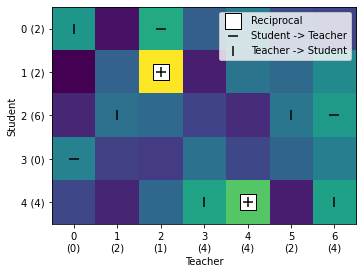

In [2]:
S = 5
T = 7
D = 16

rng = np.random.default_rng(42)
x_student = rng.normal(size=(S, 16))
x_student /= np.linalg.norm(x_student, axis=-1, keepdims=True)
x_teacher = rng.normal(size=(T, 16))
x_teacher /= np.linalg.norm(x_teacher, axis=-1, keepdims=True)

cos = np.einsum('sd, td -> st', x_student, x_teacher)

# For each row (student object),
# the index of the most similar column (teacher object)
# idx_student: [S]
idx_student = cos.argmax(-1)

# For each column (teacher object),
# the index of the most similar row (student object)
# idx_teacher: [T]
idx_teacher = cos.argmax(-2)

# For each row (small object),
# is the best-matching large object a reciprocal?
# reciprocal: [S]
reciprocal = idx_teacher[idx_student] == np.arange(S)

fig, ax = plt.subplots(1,1, facecolor='white')
ax.imshow(cos)
ax.scatter(
    idx_student[reciprocal], np.arange(S)[reciprocal], 
    color='white', marker='s', edgecolor='black', s=250, label='Reciprocal'
)
ax.scatter(idx_student, np.arange(S), color='black', marker='_', label='Student -> Teacher', s=100)
ax.scatter(np.arange(T), idx_teacher, color='black', marker='|', label='Teacher -> Student', s=100)
ax.set_xlabel('Teacher')
ax.set_xticks(np.arange(T))
ax.set_xticklabels([f'{t}\n({idx_teacher[t]})' for t in range(T)])
ax.set_ylabel('Student')
ax.set_yticks(np.arange(S))
ax.set_yticklabels([f'{s} ({idx_student[s]})' for s in range(S)])
ax.legend()
display(fig)
plt.close(fig)

Batched example in numpy:
- `B` images in the batch
- `A_student` small crops containing few objects (at most `S`)
- `A_teacher` large crops containing few objects (at most `T`)

(s, t, cos)
(2, 1, 0.3829944337240815)
(4, 3, 0.3512404377578537)


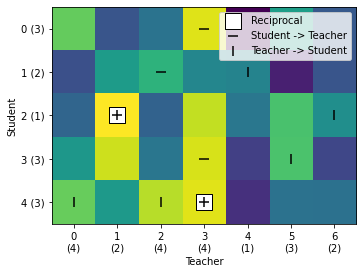

(s, t, cos)
(1, 3, 0.14199038768040992)
(4, 4, 0.4385324722495642)


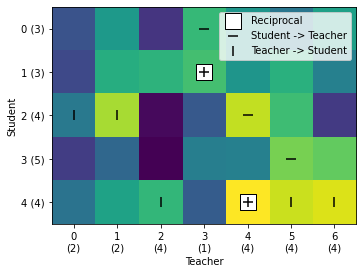

(s, t, cos)
(0, 2, 0.5241222863430367)
(2, 1, 0.21868262457170132)
(4, 6, 0.2455621782692162)


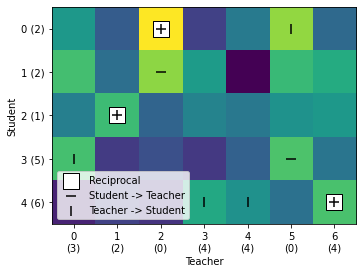

In [3]:
B = 3
A_student = 4
A_teacher = 2
S = 5
T = 7

rng = np.random.default_rng(42)
x_student = rng.normal(size=(B, A_student, S, 16))
x_student /= np.linalg.norm(x_student, axis=-1, keepdims=True)
x_teacher = rng.normal(size=(B, A_teacher, T, 16))
x_teacher /= np.linalg.norm(x_teacher, axis=-1, keepdims=True)

cos = np.einsum('bisd, bjtd -> bijst', x_student, x_teacher)

# For each row (student object),
# the index of the most similar column (teacher object)
# idx_student: [B, A_student, A_teacher, S]
idx_student = cos.argmax(-1)

# For each column (teacher object),
# the index of the most similar row (student object)
# idx_teacher: [B, A_student, A_teacher, T]
idx_teacher = cos.argmax(-2)

# For each row (student object),
# the cos similarity of the most similar column (teacher object)
# values: [B, A_student, A_teacher, S]
values = np.take_along_axis(cos, idx_student[..., None], axis=-1)[..., 0]

# For each row (small object),
# is the best-matching large object a reciprocal?
# reciprocal: [B, A_student, A_teacher, S]
reciprocal = np.take_along_axis(idx_teacher, idx_student, axis=-1) == np.arange(S)

for b_as_at in [
    (0, 0, 0),
    (0, 0, 1),
    (2, 3, 1),
]:
    print('(s, t, cos)')
    print(*zip(
        np.arange(S)[reciprocal[b_as_at]], 
        idx_student[(*b_as_at, reciprocal[b_as_at])], 
        values[(*b_as_at, reciprocal[b_as_at])],
    ), sep='\n')
    
    fig, ax = plt.subplots(1,1, facecolor='white')
    ax.imshow(cos[b_as_at])
    ax.scatter(
        idx_student[(*b_as_at, reciprocal[b_as_at])], np.arange(S)[reciprocal[b_as_at]], 
        color='white', marker='s', edgecolor='black', s=250, label='Reciprocal'
    )
    ax.scatter(idx_student[b_as_at], np.arange(S), color='black', marker='_', label='Student -> Teacher', s=100)
    ax.scatter(np.arange(T), idx_teacher[b_as_at], color='black', marker='|', label='Teacher -> Student', s=100)
    ax.set_xlabel('Teacher')
    ax.set_xticks(np.arange(T))
    ax.set_xticklabels([f'{t}\n({idx_teacher[(*b_as_at, t)]})' for t in range(T)])
    ax.set_ylabel('Student')
    ax.set_yticks(np.arange(S))
    ax.set_yticklabels([f'{s} ({idx_student[(*b_as_at, s)]})' for s in range(S)])
    ax.legend()
    
    display(fig)
    plt.close(fig)

Batched example in pytorch, a bit optimized.

(s, t, cos)
(0, 5, 0.42097396)
(2, 0, 0.6776834)
(4, 6, 0.39407194)
loss 0.49757644534111023


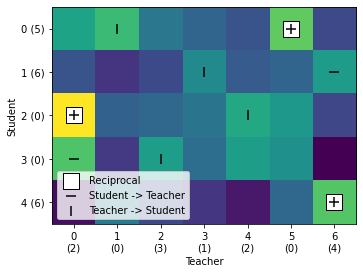

(s, t, cos)
(1, 0, 0.5158322)
(2, 4, 0.32353434)
(3, 3, 0.39437392)
loss 0.41124680638313293


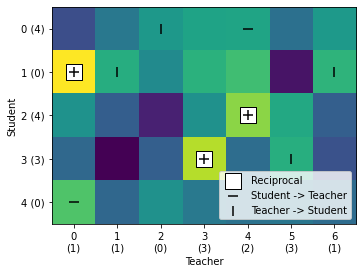

(s, t, cos)
(1, 4, 0.4257163)
(3, 3, 0.6281328)
(4, 1, 0.47870564)
loss 0.5108515620231628


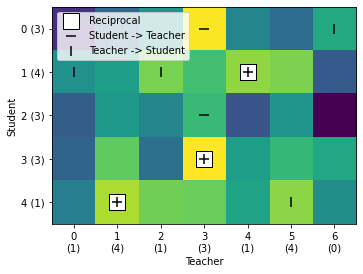

In [4]:
B = 3
A_student = 4
A_teacher = 2
S = 5
T = 7

rng = torch.Generator().manual_seed(42)
x_student = torch.randn((B, A_student, S, 16), generator=rng)
x_student /= torch.linalg.norm(x_student, dim=-1, keepdim=True)
x_teacher = torch.randn((B, A_teacher, T, 16), generator=rng)
x_teacher /= torch.linalg.norm(x_teacher, dim=-1, keepdim=True)

# Each entry at [b, aug_s, aug_t]
# is a [S, T] matrix of similarities
cos = torch.einsum('bisd, bjtd -> bijst', x_student, x_teacher)

# For each row (student object),
# the value and index of the most similar column (teacher object)
# values: [B, A_student, A_teacher, S]
# idx_student: [B, A_student, A_teacher, S]
values, idx_student = cos.max(-1)

# For each column (teacher object),
# the index of the most similar row (student object)
# idx_teacher: [B, A_student, A_teacher, T]
idx_teacher = cos.argmax(-2)

# For each row (small object),
# is the best-matching large object a reciprocal?
# reciprocal: [B, A_student, A_teacher, S]
reciprocal = idx_teacher.gather(index=idx_student, dim=-1) == torch.arange(S)

# For each entry [b, aug_s, aug_t],
# the mean similarity of matching student-teacher objects.
# loss: [B, A_student, A_teacher]
loss = torch.where(reciprocal, values, torch.tensor(torch.nan))
loss = loss.nanmean(-1)

for b_as_at in [
    (0, 0, 0),
    (0, 0, 1),
    (2, 3, 1),
]:
    print('(s, t, cos)')
    print(*zip(
        np.arange(S)[reciprocal[b_as_at]], 
        idx_student[(*b_as_at, reciprocal[b_as_at])].numpy(), 
        values[(*b_as_at, reciprocal[b_as_at])].numpy(),
    ), sep='\n')
    print('loss', loss[b_as_at].item())
    
    fig, ax = plt.subplots(1,1, facecolor='white')
    ax.imshow(cos[b_as_at])
    ax.scatter(
        idx_student[(*b_as_at, reciprocal[b_as_at])], np.arange(S)[reciprocal[b_as_at]], 
        color='white', marker='s', edgecolor='black', s=250, label='Reciprocal'
    )
    ax.scatter(idx_student[b_as_at], np.arange(S), color='black', marker='_', label='Student -> Teacher', s=100)
    ax.scatter(np.arange(T), idx_teacher[b_as_at], color='black', marker='|', label='Teacher -> Student', s=100)
    ax.set_xlabel('Teacher')
    ax.set_xticks(np.arange(T))
    ax.set_xticklabels([f'{t}\n({idx_teacher[(*b_as_at, t)]})' for t in range(T)])
    ax.set_ylabel('Student')
    ax.set_yticks(np.arange(S))
    ax.set_yticklabels([f'{s} ({idx_student[(*b_as_at, s)]})' for s in range(S)])
    ax.legend()
    
    display(fig)
    plt.close(fig)